# I. Import libraries and load dataset

In [1]:
!pip install ucimlrepo
!pip install optuna

In [2]:
import os
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import optuna
from sklearn.compose import ColumnTransformer

In [3]:
class CFG:
    seed = 42
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    SMALL_GAP = 6
    lookback = 24
    horizon = 2
    epochs = 10
    lr = 1e-3
    models_dir = './models'
    os.makedirs(models_dir, exist_ok=True)

torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
if CFG.device == 'cuda':
    torch.cuda.manual_seed_all(CFG.seed)

MASK_VALUE = 0.0

#### Load dataset

In [4]:
metro_interstate_traffic_volume = fetch_ucirepo(id=492)

X = metro_interstate_traffic_volume.data.features
y = metro_interstate_traffic_volume.data.targets

# II. Sanity check and EDA

In [5]:
df = X.copy()
df['traffic_volume'] = y.copy()
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Check columns data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### 1. Transform date_time column to datetime format

In [7]:
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.sort_values("date_time").reset_index(drop=True)

### 2. Drop duplicated rows

In [8]:
df.duplicated().sum()

np.int64(17)

In [9]:
df.drop_duplicates(inplace=True)

Check features statistics and distribution

In [10]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
count,48187.000000,48187.000000,48187.000000,48187.000000,48187,48187.000000
mean,281.204995,0.334382,0.000222,49.365451,2016-01-05 06:49:48.133729024,3259.618134
min,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000
25%,272.160000,0.000000,0.000000,1.000000,2014-02-06 07:30:00,1192.500000
50%,282.450000,0.000000,0.000000,64.000000,2016-06-10 21:00:00,3379.000000
75%,291.806000,0.000000,0.000000,90.000000,2017-08-11 05:30:00,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,2018-09-30 23:00:00,7280.000000
std,13.338738,44.797033,0.008169,39.015213,NaN,1986.954465


Unit of measurement:
- temp: Kelvin
- rain_1h: mm
- snow_1h: mm
- clouds_all: %

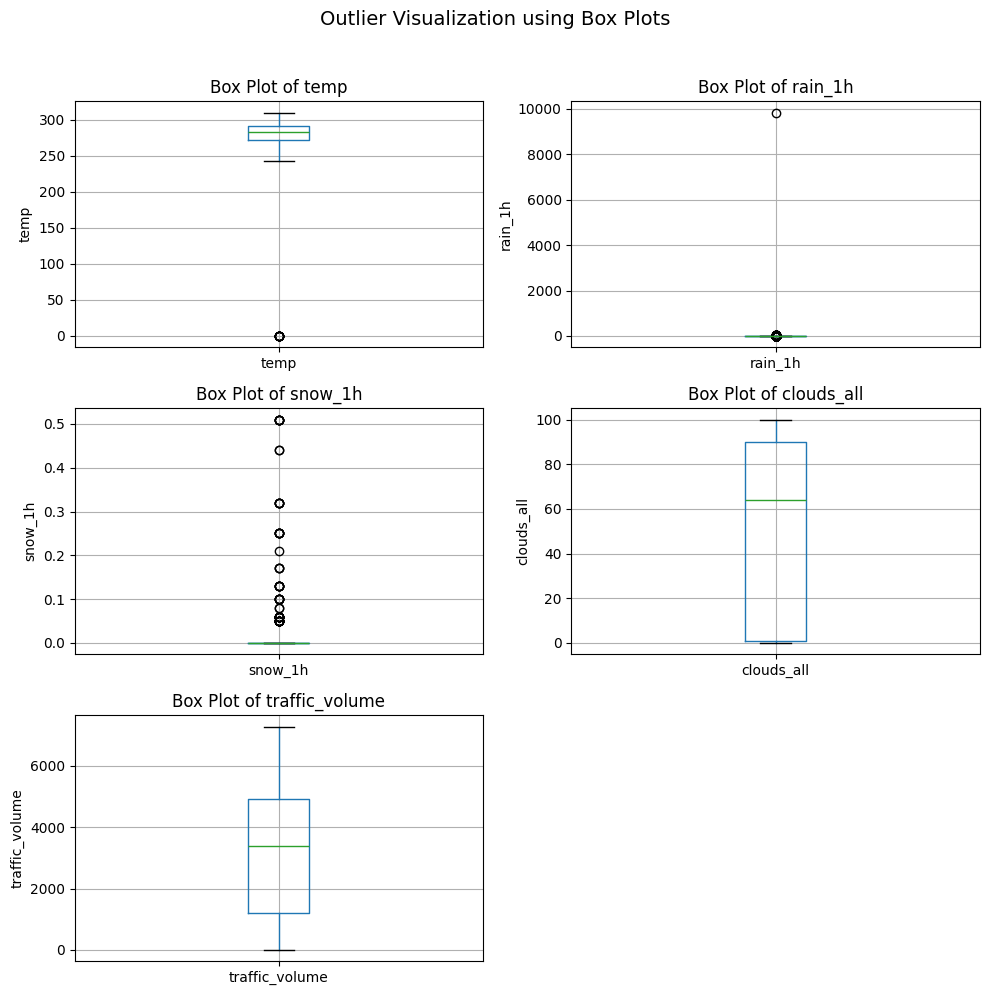

In [11]:
numerical_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # <-- giảm từ (15,15) xuống (10,10)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)   # giảm font
    axes[i].set_ylabel(col, fontsize=10)

# Xóa subplot thừa
if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Outlier Visualization using Box Plots', fontsize=14, y=1.02)  # giảm font
plt.tight_layout(rect=[0, 0.03, 1, 1.0])
plt.show()

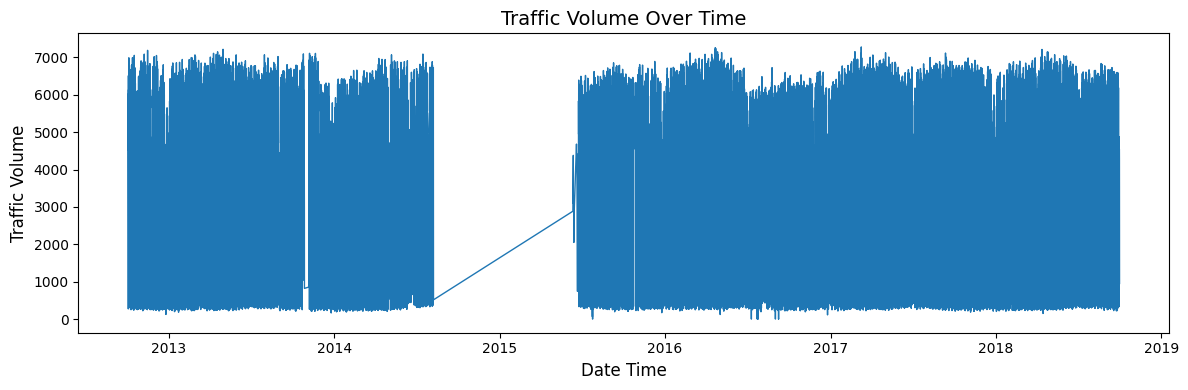

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(df['date_time'], df['traffic_volume'], linewidth=1)
plt.title("Traffic Volume Over Time", fontsize=14)
plt.xlabel("Date Time", fontsize=12)
plt.ylabel("Traffic Volume", fontsize=12)
plt.tight_layout()
plt.show()

- The data exhibits high seasonality and volatility
- There are large missing data gaps

### 3. Handle invalid data

temp

In [13]:
df[df['temp'] == df['temp'].min()]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


In [14]:
df['temp'] = df['temp'].replace(0, np.nan)

rain_1h

In [15]:
df[df['rain_1h'] == df['rain_1h'].max()]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,NaN,302.11,9831.3,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535


In [16]:
real_max_rain = df.loc[df['rain_1h'] < 100, 'rain_1h'].max()
df.loc[df['rain_1h'] > 100, 'rain_1h'] = real_max_rain

### 4. Handle missing values in 'holiday' column

In [17]:
df['holiday'].unique()

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [18]:
df['holiday'] = df['holiday'].fillna('None')
df['is_holiday'] = (df['holiday'] != 'None').astype(int)
df = df.drop(columns=["holiday"])

### 5. Aggregate duplicated timestamps

In [19]:
df['date_time'].duplicated().sum()

np.int64(7612)

In [20]:
df['date_time'].value_counts()[lambda x: x > 1]

,count
date_time,
2013-05-19 10:00:00,6
2013-04-18 22:00:00,6
2016-12-25 21:00:00,5
2012-12-16 19:00:00,5
2012-12-16 21:00:00,5
...,...
2013-02-10 08:00:00,2
2013-02-11 21:00:00,2
2018-06-17 20:00:00,2


In [21]:
numeric_cols = ["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]
cate_col = ['weather_description', 'weather_main']
first_cols = ["is_holiday"]

# Mode function
def get_mode(x):
    m = pd.Series.mode(x)
    return m.iloc[0] if not m.empty else np.nan

df_grouped = df.groupby("date_time").agg(
    {**{c: "mean" for c in numeric_cols},
     **{c: get_mode for c in cate_col},
     **{c: "max" for c in first_cols}}
).reset_index()

### 6. Handle missing timestamps

In [22]:
start = df["date_time"].min()
end = df["date_time"].max()
print(start)
print(end)

2012-10-02 09:00:00
2018-09-30 23:00:00


In [23]:
total_hours = int((end - start) / pd.Timedelta(hours=1)) + 1
print("Số giờ liên tục dự kiến:", total_hours)
print("Số bản ghi trong dataset:", len(df_grouped))

Số giờ liên tục dự kiến: 52551
Số bản ghi trong dataset: 40575


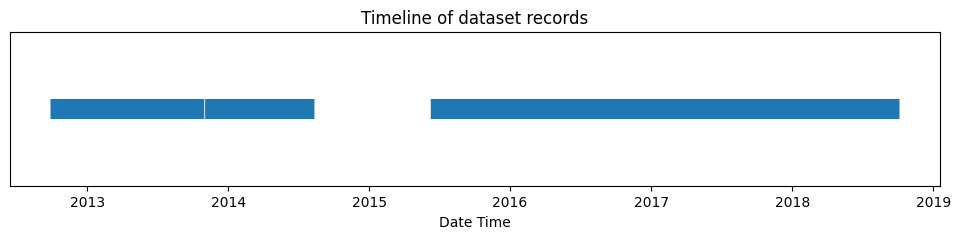

In [24]:
df_sorted = df_grouped.sort_values('date_time')

plt.figure(figsize=(12,2))
plt.scatter(df_sorted['date_time'], [1]*len(df_sorted), marker='|', s=200)
plt.yticks([])
plt.title("Timeline of dataset records")
plt.xlabel("Date Time")
plt.show()

In [25]:
df_sorted['gap'] = df_sorted['date_time'].diff()
top_gaps = df_sorted[['date_time', 'gap']].sort_values('gap', ascending=False).head(10)

print(top_gaps)

                date_time               gap
13898 2015-06-11 20:00:00 307 days 19:00:00
8131  2013-11-06 04:00:00  10 days 03:00:00
13905 2015-06-19 18:00:00   4 days 22:00:00
12188 2014-05-04 05:00:00   4 days 21:00:00
16596 2015-10-27 08:00:00   3 days 21:00:00
13737 2014-07-30 09:00:00   2 days 17:00:00
7339  2013-09-01 23:00:00   1 days 23:00:00
13909 2015-06-24 04:00:00   1 days 10:00:00
13800 2014-08-03 11:00:00   1 days 09:00:00
7365  2013-09-04 08:00:00   1 days 06:00:00


In [26]:
full_range = pd.date_range(start=start, end=end, freq="h")

df_full = df_sorted.set_index('date_time').reindex(full_range)
df_full.index.name = 'date_time'

# Đánh dấu dữ liệu gốc có tồn tại hay không
original_exists = df.set_index('date_time').index
df_full['timestep_mask'] = df_full.index.isin(original_exists).astype(int)

cols_to_interp = ["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]

#### Mask for small gaps

Only interpolated points within the 'small gap' limit will be considered valid data

In [27]:
mask_filled = np.ones(len(df_full), dtype=bool)

for col in cols_to_interp:
    mask_col = df_full[col].interpolate(
        method="time",
        limit=CFG.SMALL_GAP,
        limit_direction="forward"
    ).notna()

    mask_filled &= mask_col

mask_filled = mask_filled.astype(int)

#### Interpolate

In [28]:
df_full[cols_to_interp] = df_full[cols_to_interp].interpolate(method='time', limit=CFG.SMALL_GAP, limit_direction='forward')
df_full[cate_col] = df_full[cate_col].ffill(limit=CFG.SMALL_GAP)

#### Fill large timestamp gaps with 0

Gaps that are too large (exceeding the limit) will remain NaN, which are then filled with 0 or ignored during training

In [29]:
df_full['timestep_mask'] = mask_filled
df_full[cols_to_interp] = df_full[cols_to_interp].fillna(0)

#### Interpolate 'is_holiday' in small gaps using data from the same day in other years

Retrieve the list of holiday dates from the original data and re-assign the entire day as a holiday

In [30]:
df_full = df_full.reset_index()
df_full['date_only'] = df_full['date_time'].dt.date

holiday_dates = df_full[df_full['is_holiday'] == 1]['date_only'].dropna().unique()

df_full['is_holiday'] = df_full['date_only'].isin(holiday_dates).astype(int)

df_full = df_full.drop(columns=['date_only'])

### 7. Handle statistical outliers

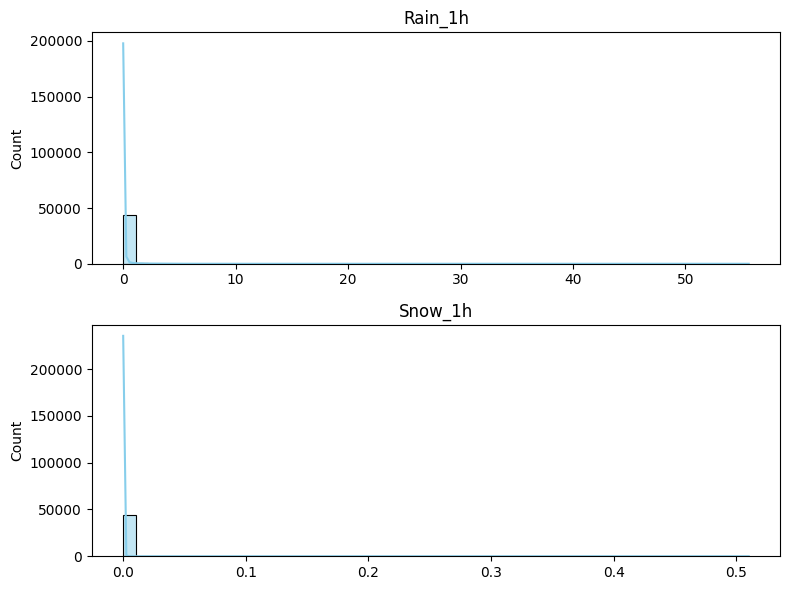

In [31]:
mask_valid = df_full['timestep_mask'] == 1
rain_valid = df_full.loc[mask_valid, 'rain_1h'].values
snow_valid = df_full.loc[mask_valid, 'snow_1h'].values

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(rain_valid, bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Rain_1h")

sns.histplot(snow_valid, bins=50, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title("Snow_1h")

plt.tight_layout()
plt.show()


Most hours have no or only a small amount of rain/snow, resulting in values close to 0. Some hours have heavy rain/snow, resulting in large values. Result: the data distribution is asymmetrical with a long right tail (skewed). Therefore, a log transformation should be applied to handle the skewness.

In [32]:
df_full["rain_log"] = np.log1p(df_full["rain_1h"]) #log(1 + x)
df_full["snow_log"] = np.log1p(df_full["snow_1h"])

#  III. Feature Engineering

### 1. Encoding 'weather_description' and dropping 'weather_main'

In [33]:
df_full['weather_main'].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Fog', nan,
       'Thunderstorm', 'Haze', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [34]:
df_full['weather_description'].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog', 'drizzle',
       'moderate rain', 'heavy intensity rain', nan,
       'proximity thunderstorm', 'heavy snow', 'snow',
       'proximity thunderstorm with rain', 'light intensity shower rain',
       'SQUALLS', 'thunderstorm with heavy rain',
       'heavy intensity drizzle', 'Sky is Clear',
       'thunderstorm with light drizzle', 'thunderstorm',
       'very heavy rain', 'light snow', 'thunderstorm with light rain',
       'proximity shower rain', 'freezing rain', 'light shower snow',
       'thunderstorm with rain', 'smoke'], dtype=object)

#### Mapping based on train data, then apply to validation/test data

In [35]:
train_split_idx = int(0.7 * len(df_full))
train_cutoff_time = df_full.iloc[train_split_idx].name

train_subset = df_full[
    (df_full.index <= train_cutoff_time) &
    (df_full['timestep_mask'] == 1)
]

#### The score for each weather type is the average traffic volume for that weather type

In [36]:
weather_score_map = train_subset.groupby('weather_description')['traffic_volume'].mean().to_dict()

# Apply to whole dataset
df_full['weather_score'] = df_full['weather_description'].map(weather_score_map)

#### Handle missing values after mapping

If a weather type appears in the validation/test set that was not seen in the training set, its score will be filled with the global mean of the training set.

In [37]:
global_mean_score = train_subset['traffic_volume'].mean()
df_full['weather_score'] = df_full['weather_score'].fillna(global_mean_score)

df_full = df_full.drop(columns=['weather_description', 'weather_main'])

### 2. Add time feature

#### Các biến không được đưa vào model
- day vì nó discontinue (ví dụ ngày 31 và ngày 1 sát nhau nhưng về mặt con số cách xa nhau)

- year vì các năm ở tập test chưa có trên tập train nên khi scacling trên tập test sẽ tạo ra giá trị > 1

- month vì có month sin cos

- hour vì có hour sin cos

- day_of_week vì có dow sin cos

- trend vì tăng dần vô hạn, khi scaling trên tập test sẽ tạo ra khoảng max và tạo giá trị >1

In [38]:
month = df_full["date_time"].dt.month
hour = df_full["date_time"].dt.hour
day_of_week = df_full["date_time"].dt.dayofweek
trend = np.arange(len(df_full))
week_hour = day_of_week*24 + hour

#### Binary features

In [39]:
df_full["is_weekend"] = (day_of_week >= 5).astype(int)
df_full["is_rain"] = (df_full["rain_1h"] > 0).astype(int)
df_full["is_snow"] = (df_full["snow_1h"] > 0).astype(int)

#### Cyclical temporal features

In [40]:
df_full["hour_sin"] = np.sin(2*np.pi*hour/24)
df_full["hour_cos"] = np.cos(2*np.pi*hour/24)
df_full["dow_sin"] = np.sin(2*np.pi*day_of_week/7)
df_full["dow_cos"] = np.cos(2*np.pi*day_of_week/7)
df_full["month_sin"] = np.sin(2*np.pi*month/12)
df_full["month_cos"] = np.cos(2*np.pi*month/12)

#### Weekly Fourier features

In [41]:
df_full['sin_168'] = np.sin(2*np.pi*week_hour/168)
df_full['cos_168'] = np.cos(2*np.pi*week_hour/168)

#### Yearly Fourier features

In [42]:
df_full["fourier_sin_year"] = np.sin(2*np.pi*trend/(365*24))
df_full["fourier_cos_year"] = np.cos(2*np.pi*trend/(365*24))

### 3. Add Lag and rolling mean features

In [43]:
full_y = df_full['traffic_volume']

#### Lag features for 'traffic_volume'

In [44]:
lags = [1, 24, 168]
for l in lags:
    df_full[f'lag{l}'] = full_y.shift(l)
    df_full[f'lag{l}_mask'] = df_full['timestep_mask'].shift(l).fillna(0).astype(int)

#### Rolling mean features for 'traffic_volume'

In [45]:
y_lagged = full_y.shift(1)
windows = [3, 6, 24, 168]
for w in windows:
    df_full[f'roll_mean{w}'] = y_lagged.rolling(window=w, min_periods=w).mean()
    df_full[f'roll_mask{w}'] = (df_full['timestep_mask'].shift(1).rolling(window=w, min_periods=w).sum() == w).astype(int)

#### Lag features for weather-related columns

In [46]:
weather_cols = ["temp", "rain_1h", "snow_1h", "clouds_all", "weather_score"]
for col in weather_cols:
    df_full[f"{col}_lag1"] = df_full[col].shift(1)
    df_full[f"{col}_lag1_mask"] = df_full['timestep_mask'].shift(1).fillna(0).astype(int)

#### Masking missing values resulting from shifted/rolling features

In [47]:
mask_cols = [c for c in df_full.columns if "_mask" in c]
df_full['valid_row'] = df_full[mask_cols].all(axis=1)

In [48]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52551 entries, 0 to 52550
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   date_time                52551 non-null  datetime64[ns] 
 1   temp                     52551 non-null  float64        
 2   rain_1h                  52551 non-null  float64        
 3   snow_1h                  52551 non-null  float64        
 4   clouds_all               52551 non-null  float64        
 5   traffic_volume           52551 non-null  float64        
 6   is_holiday               52551 non-null  int64          
 7   gap                      40574 non-null  timedelta64[ns]
 8   timestep_mask            52551 non-null  int64          
 9   rain_log                 52551 non-null  float64        
 10  snow_log                 52551 non-null  float64        
 11  weather_score            52551 non-null  float64        
 12  is_weekend        

#  IV. Scaling

Only numerical features and observations marked as valid (mask = 1) are used for scaling

In [49]:
feature_cols = [
    "temp", "rain_log", "clouds_all", "snow_log",
    "is_holiday", "weather_score",
    "is_weekend", "is_rain", "is_snow",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos",
    "sin_168", "cos_168",
    "fourier_sin_year", "fourier_cos_year",
]

X_all = df_full[feature_cols].values.astype(np.float32)
y_all = df_full[['traffic_volume']].values.astype(np.float32)
mask_all = df_full['valid_row'].values

total_len = len(X_all)
train_end_idx = int(0.7 * total_len)
val_end_idx   = int(0.8 * total_len)

X_train_raw = X_all[:train_end_idx]
X_val_raw = X_all[train_end_idx:val_end_idx]
X_test_raw = X_all[val_end_idx:]

y_train_raw = y_all[:train_end_idx]
y_val_raw   = y_all[train_end_idx:val_end_idx]
y_test_raw  = y_all[val_end_idx:]

mask_train = mask_all[:train_end_idx]
mask_val = mask_all[train_end_idx:val_end_idx]
mask_test = mask_all[val_end_idx:]
train_valid_idx = mask_train == 1

#### Identify columns that need scaling

In [50]:
numeric_cols = [
    "temp", "rain_log", "clouds_all", "snow_log", "weather_score",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos",
    "sin_168", "cos_168",
    "fourier_sin_year", "fourier_cos_year",
]

passthrough_cols = [
    "is_holiday", "is_weekend", "is_rain", "is_snow"
]

scaler_X = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), numeric_cols),
        ("pass", "passthrough", passthrough_cols)
    ],
    remainder="drop"
)

#### Fit on the training set

In [51]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train_raw[train_valid_idx])

scaler_y = MinMaxScaler()
scaler_y.fit(y_train_raw[train_valid_idx])

MinMaxScaler()

#### Transform on training/validation/test sets

The scalers are fitted only on the training set and then applied to the entire dataset to prevent data leakage

In [52]:
X_train = scaler_X.transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = scaler_y.transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

In [53]:
print("Train shape:", X_train.shape)
print("Feature order:", scaler_X.get_feature_names_out())

Train shape: (36785, 19)
Feature order: ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13'
 'x14' 'x15' 'x16' 'x17' 'x18']


# V. Data preparation for training

#### The get_blocks function

Finds continuous regions where the mask equals 1, and then divides these regions into blocks

In [54]:
def get_blocks(mask):
    mask = np.array(mask)
    padded = np.r_[0, mask, 0]
    diff = np.diff(padded)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return list(zip(starts, ends))

####  The BreakSequenceDataset class

Each block is treated as an independent sequence. For each block that is long enough (lookback + horizon), sliding windows are generated:

- x_seq: the past 'lookback' steps
- y_seq: the next 'horizon' steps (the target)

Each sample is returned as a tuple of tensors (x_tensor, y_tensor).

In [55]:
class BreakSequenceDataset(Dataset):
    def __init__(self, X, y, mask, lookback, horizon):
        self.lookback = lookback
        self.horizon = horizon
        self.samples = []

        X, y, mask = np.array(X), np.array(y), np.array(mask)
        for start, end in get_blocks(mask):
            L = end - start
            if L < lookback + horizon:
                continue
            for i in range(start, end - lookback - horizon + 1):
                x_seq = X[i:i+lookback]
                y_seq = y[i+lookback:i+lookback+horizon]
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y.reshape(-1), dtype=torch.float32)

#### Create datasets

In [56]:
train_ds = BreakSequenceDataset(X_train, y_train, mask_train, CFG.lookback, CFG.horizon)
val_ds   = BreakSequenceDataset(X_val, y_val, mask_val, CFG.lookback, CFG.horizon)
test_ds  = BreakSequenceDataset(X_test, y_test, mask_test, CFG.lookback, CFG.horizon)

Shape of a single sequence:

In [57]:
x, y = train_ds[0]
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: torch.Size([24, 19])
y shape: torch.Size([2])


Input (X tensor shape: [lookback, n_features]):
- 24: 'lookback' - the number of past timesteps the model uses for prediction (24 hours in the past)
- 19: the number of features at each timestep

Output (Y tensor shape: [horizon]):
- 2: 'horizon' - the number of future steps to predict

Total number of sequences

In [58]:
print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))

Train samples: 23691
Val samples: 4840
Test samples: 10486


- Train dataset: 23,691 sequence

- Val dataset: 4,840 sequence

- Test dataset: 10,486 sequence

#### Create dataloaders

In [59]:
train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

Shuffling changes the order of the sequences, but the timestamp order within each sequence remains unchanged. Shuffling the training data helps the model learn better, prevents overfitting, and stabilizes the gradient. The validation and test sets are kept unshuffled to evaluate performance in real time order and simulate actual prediction.

The sequences will be divided into batches to be fed into the model.

In [60]:
batch_x, batch_y = next(iter(train_loader))

print("batch_x shape:", batch_x.shape)
print("batch_y shape:", batch_y.shape)

batch_x shape: torch.Size([64, 24, 19])
batch_y shape: torch.Size([64, 2])


Each batch contains 64 sequences

#  VI. Model

### 1. Simple LSTM

In [61]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden, batch_first=True)
        self.head = nn.Linear(hidden, horizon)
    def forward(self, x):
        out, _ = self.lstm(x)
        out_last = out[:, -1, :]
        return self.head(out_last)

In [62]:
def train_loop(model, train_loader, val_loader, epochs=10, lr=1e-3):
    device = torch.device(CFG.device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_losses.append(criterion(pred, yb).item())
        avg_tr, avg_val = np.mean(train_losses), np.mean(val_losses)
        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
        print(f'Epoch {ep}/{epochs} train_loss={avg_tr:.6f} val_loss={avg_val:.6f}')

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

#### Evaluation

In [63]:
def evaluate_model(model, loader, scaler_y, eps=1e-3):
    device = torch.device(CFG.device)
    model.eval()

    Ys = []
    Ps = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb)
            Ys.append(yb.numpy())
            Ps.append(pred.cpu().numpy())

    Y = np.vstack(Ys)
    P = np.vstack(Ps)

    Y_inv = scaler_y.inverse_transform(Y)
    P_inv = scaler_y.inverse_transform(P)

    mae  = mean_absolute_error(Y_inv, P_inv)
    rmse = np.sqrt(mean_squared_error(Y_inv, P_inv))
    r2 = r2_score(Y_inv, P_inv)
    #NSE
    numerator = np.sum((Y_inv - P_inv)**2)
    denominator = np.sum((Y_inv - np.mean(Y_inv))**2) + eps
    nse = 1 - numerator / denominator


    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "NSE": nse,
        "R2": r2
    }
    return metrics, Y_inv, P_inv

In [64]:
model = SimpleLSTM(input_dim=X_train.shape[1], hidden=128, horizon=CFG.horizon)
model = train_loop(model, train_loader, val_loader, epochs=CFG.epochs, lr=CFG.lr)

metrics_train, Y_train_inv, P_train_inv = evaluate_model(model, train_loader, scaler_y)
metrics_val,   Y_val_inv,   P_val_inv   = evaluate_model(model, val_loader, scaler_y)

print("Train Metrics:", metrics_train)
print("Val Metrics:", metrics_val)

Epoch 1/10 train_loss=0.021515 val_loss=0.005609
Epoch 2/10 train_loss=0.006326 val_loss=0.003881
Epoch 3/10 train_loss=0.005243 val_loss=0.003099
Epoch 4/10 train_loss=0.004858 val_loss=0.004177
Epoch 5/10 train_loss=0.004587 val_loss=0.002923
Epoch 6/10 train_loss=0.004439 val_loss=0.003182
Epoch 7/10 train_loss=0.004361 val_loss=0.002967
Epoch 8/10 train_loss=0.004165 val_loss=0.003336
Epoch 9/10 train_loss=0.004100 val_loss=0.003210
Epoch 10/10 train_loss=0.003967 val_loss=0.002848
Train Metrics: {'MAE': 279.09185791015625, 'RMSE': np.float64(436.8764127301908), 'NSE': np.float32(0.95059544), 'R2': 0.9505957365036011}
Val Metrics: {'MAE': 247.11734008789062, 'RMSE': np.float64(388.1504420002636), 'NSE': np.float32(0.96046877), 'R2': 0.9604688882827759}


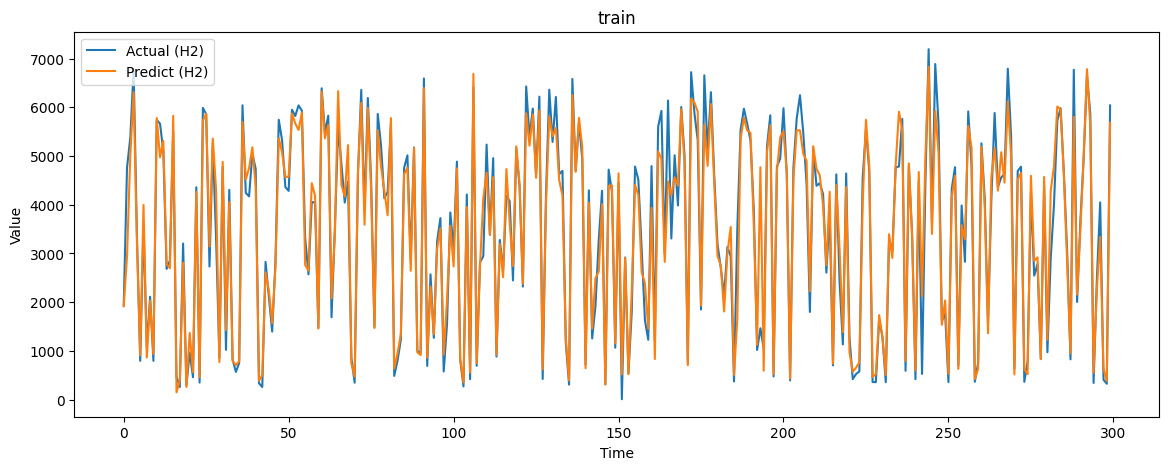

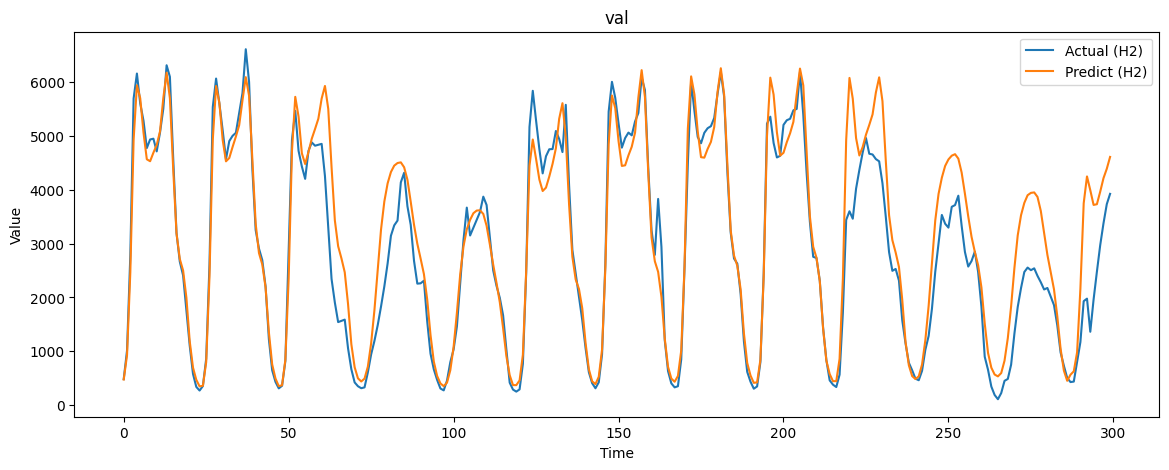

In [65]:
def plot_horizon2(Y, P, chart_name, max_points=300):
    N = min(len(Y), max_points)

    plt.figure(figsize=(14, 5))
    plt.plot(Y[:N, 1], label='Actual (H2)')
    plt.plot(P[:N, 1], label='Predict (H2)')
    plt.title(f'{chart_name}')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

metrics, Y_inv, P_inv = evaluate_model(model, test_loader, scaler_y)

plot_horizon2(Y_train_inv, P_train_inv, 'train')
plot_horizon2(Y_val_inv, P_val_inv, 'val')

#### Hyperparameter tunning

In [66]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])

    # DataLoaders
    train_loader_opt = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader_opt   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Model
    model = SimpleLSTM(input_dim=X_train.shape[1], hidden=hidden_size, horizon=CFG.horizon).to(CFG.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")

    EPOCHS_OPT = 10
    for ep in range(EPOCHS_OPT):
        model.train()
        for xb, yb in train_loader_opt:
            xb, yb = xb.to(CFG.device), yb.to(CFG.device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        Ys, Ps = [], []
        with torch.no_grad():
            for xb, yb in val_loader_opt:
                xb = xb.to(CFG.device)
                pred = model(xb)
                Ys.append(yb.cpu().numpy())
                Ps.append(pred.cpu().numpy())

        Y_val = np.vstack(Ys)
        P_val = np.vstack(Ps)

        # Inverse scaling
        Y_val_inv = scaler_y.inverse_transform(Y_val)
        P_val_inv = scaler_y.inverse_transform(P_val)

        val_mae = mean_absolute_error(Y_val_inv, P_val_inv)

        trial.report(val_mae, ep)

        if val_mae < best_val_loss:
            best_val_loss = val_mae

        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial hyperparams:")
print(study.best_trial.params)
print("Best MAE:", study.best_trial.value)

[I 2025-12-03 04:33:24,710] A new study created in memory with name: no-name-99655656-0994-44e0-855d-a45fc221cdf5
[I 2025-12-03 04:33:34,011] Trial 0 finished with value: 277.4747009277344 and parameters: {'hidden_size': 51, 'lr': 0.0010398516361076902, 'batch_size': 128}. Best is trial 0 with value: 277.4747009277344.
[I 2025-12-03 04:33:45,165] Trial 1 finished with value: 262.2966003417969 and parameters: {'hidden_size': 132, 'lr': 0.005069201722634411, 'batch_size': 128}. Best is trial 1 with value: 262.2966003417969.
[I 2025-12-03 04:34:12,001] Trial 2 finished with value: 252.67684936523438 and parameters: {'hidden_size': 193, 'lr': 0.007228282899705735, 'batch_size': 32}. Best is trial 2 with value: 252.67684936523438.
[I 2025-12-03 04:34:43,401] Trial 3 finished with value: 263.95269775390625 and parameters: {'hidden_size': 143, 'lr': 0.002709044271924454, 'batch_size': 32}. Best is trial 2 with value: 252.67684936523438.
[I 2025-12-03 04:35:10,366] Trial 4 finished with value:

Best trial hyperparams:
{'hidden_size': 243, 'lr': 0.0020740628607297438, 'batch_size': 32}
Best MAE: 247.1558837890625


In [67]:
best_params = study.best_trial.params
hidden_size = best_params["hidden_size"]
lr          = best_params["lr"]
batch_size  = best_params["batch_size"]

train_loader_best = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_best   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader_best  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Model final
model_best = SimpleLSTM(input_dim=X_train.shape[1], hidden=hidden_size, horizon=CFG.horizon)
model_best = train_loop(model_best, train_loader_best, val_loader_best, epochs=CFG.epochs, lr=lr)

# Evaluate Test
metrics_test, Y_test_inv, P_test_inv = evaluate_model(model_best, test_loader_best, scaler_y)
print("\nTest Metrics with best params:")
print(metrics_test)

Epoch 1/10 train_loss=0.011350 val_loss=0.004836
Epoch 2/10 train_loss=0.005540 val_loss=0.003890
Epoch 3/10 train_loss=0.004927 val_loss=0.003532
Epoch 4/10 train_loss=0.004660 val_loss=0.003265
Epoch 5/10 train_loss=0.004357 val_loss=0.003966
Epoch 6/10 train_loss=0.004287 val_loss=0.002969
Epoch 7/10 train_loss=0.004127 val_loss=0.003030
Epoch 8/10 train_loss=0.003933 val_loss=0.003472
Epoch 9/10 train_loss=0.003851 val_loss=0.002948
Epoch 10/10 train_loss=0.003731 val_loss=0.003476

Test Metrics with best params:
{'MAE': 296.109130859375, 'RMSE': np.float64(459.5781353589398), 'NSE': np.float32(0.9463667), 'R2': 0.9463666677474976}


### 2. Encode - Decoder LSTM

#### 2.1 Prepare dataset

In [68]:
horizon_task_2 = 5

train_ds = BreakSequenceDataset(X_train, y_train, mask_train, CFG.lookback, horizon_task_2)
val_ds   = BreakSequenceDataset(X_val, y_val, mask_val, CFG.lookback, horizon_task_2)
test_ds  = BreakSequenceDataset(X_test, y_test, mask_test, CFG.lookback, horizon_task_2)

In [69]:
X_mini, y_mini = train_ds[0]

In [70]:
X_mini.shape

torch.Size([24, 19])

In [71]:
y_mini.shape

torch.Size([5])

In [72]:
train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

In [73]:
batch_x, batch_y = next(iter(train_loader))

print("batch_x shape:", batch_x.shape)
print("batch_y shape:", batch_y.shape)

batch_x shape: torch.Size([64, 24, 19])
batch_y shape: torch.Size([64, 5])


#### 2.2 Model

Model and Evaluation function

In [74]:
# ============================================================
# 1. Encoder–Decoder LSTM Model
# ============================================================
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        output, (h, c) = self.lstm(x)
        return h, c


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, y_prev, h, c):
        # y_prev: (batch, 1, output_dim)
        output, (h, c) = self.lstm(y_prev, (h, c))
        pred = self.fc(output)  # (batch, 1, output_dim)
        return pred, h, c


class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, future_steps, num_layers=1):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers)
        self.decoder = Decoder(output_dim, hidden_dim, num_layers)
        self.future_steps = future_steps
        self.output_dim = output_dim

    def forward(self, x, teacher_forcing_ratio=0.5, y=None):
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, self.future_steps, self.output_dim).to(x.device)

        # Encode
        h, c = self.encoder(x)

        # First decoder input = zeros or last value of encoder
        decoder_input = torch.zeros(batch_size, 1, self.output_dim).to(x.device)

        for t in range(self.future_steps):
            out, h, c = self.decoder(decoder_input, h, c)
            outputs[:, t:t+1, :] = out

            if (y is not None) and (torch.rand(1).item() < teacher_forcing_ratio):
                # Teacher forcing: use true label
                decoder_input = y[:, t:t+1, :].unsqueeze(-1) if y.dim() == 2 else y[:, t:t+1, :]
            else:
                # Use prediction
                decoder_input = out

        return outputs



# ============================================================
# 2. Training Loop + Validation
# ============================================================
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs,  device ,teacher_forcing_ratio=0.5):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # (B, 24, 19)
            y_batch = y_batch.to(device).unsqueeze(-1)  # (B, 5, 1)

            optimizer.zero_grad()

            y_pred = model(X_batch, y=y_batch, teacher_forcing_ratio=teacher_forcing_ratio)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).unsqueeze(-1)

                y_pred = model(X_batch, y=None, teacher_forcing_ratio=teacher_forcing_ratio)

                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} "
              f"| Val Loss: {val_loss/len(val_loader):.4f}")


# ============================================================
# Evaluation
# ============================================================
def evaluate_model_encoder_decoder(model, loader, scaler_y, eps=1e-3):
    device = torch.device(CFG.device)
    model.eval()

    Ys_processed = []
    Ps_processed = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)

            # Ensure yb is 3D: (batch_size, horizon, 1) for consistent processing
            if yb.dim() == 2:
                yb_tensor = yb.unsqueeze(-1) # Add output_dim=1
            else:
                yb_tensor = yb

            pred_tensor = model(xb)

            # Ensure pred_tensor is 3D: (batch_size, horizon, output_dim)
            if pred_tensor.dim() == 2:
                # If output is (batch_size, horizon), make it (batch_size, horizon, 1)
                pred_tensor = pred_tensor.unsqueeze(-1)
            elif pred_tensor.dim() == 1: # Handle case where horizon=1 and output is (batch_size)
                # Make it (batch_size, 1, 1)
                pred_tensor = pred_tensor.unsqueeze(-1).unsqueeze(-1)

            Ys_processed.append(yb_tensor.cpu().numpy())
            Ps_processed.append(pred_tensor.cpu().numpy())

    Y = np.vstack(Ys_processed)  # Stacks to (total_samples, horizon, output_dim)
    P = np.vstack(Ps_processed)  # Stacks to (total_samples, horizon, output_dim)

    # Store original shapes to reshape back after inverse_transform
    original_Y_shape = Y.shape
    original_P_shape = P.shape

    # Reshape to 2D (total_elements, output_dim) for scaler
    Y_reshaped_for_scaler = Y.reshape(-1, Y.shape[-1])
    P_reshaped_for_scaler = P.reshape(-1, P.shape[-1])

    Y_inv_reshaped = scaler_y.inverse_transform(Y_reshaped_for_scaler)
    P_inv_reshaped = scaler_y.inverse_transform(P_reshaped_for_scaler)

    # Reshape back to original 3D structure (total_samples, horizon, output_dim)
    Y_inv = Y_inv_reshaped.reshape(original_Y_shape)
    P_inv = P_inv_reshaped.reshape(original_P_shape)

    # Flatten for metric calculation, as sklearn metrics typically expect 1D or 2D inputs where each row is a sample
    Y_inv_flat = Y_inv.reshape(-1)
    P_inv_flat = P_inv.reshape(-1)

    mae  = mean_absolute_error(Y_inv_flat, P_inv_flat)
    rmse = np.sqrt(mean_squared_error(Y_inv_flat, P_inv_flat))
    r2 = r2_score(Y_inv_flat, P_inv_flat)
    # NSE
    numerator = np.sum((Y_inv_flat - P_inv_flat)**2)
    denominator = np.sum((Y_inv_flat - np.mean(Y_inv_flat))**2) + eps
    nse = 1 - numerator / denominator

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "NSE": nse,
        "R2": r2
    }
    return metrics, Y_inv, P_inv

Trainning

In [75]:
model_encoder_decoder = LSTMSeq2Seq(input_dim=19, hidden_dim=64, output_dim=1,  future_steps=horizon_task_2)
optimizer = torch.optim.Adam(model_encoder_decoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_model(model_encoder_decoder, train_loader, val_loader, optimizer, criterion, epochs=10, device=CFG.device)

Epoch 1/10 | Train Loss: 0.0266 | Val Loss: 0.0048
Epoch 2/10 | Train Loss: 0.0052 | Val Loss: 0.0038
Epoch 3/10 | Train Loss: 0.0044 | Val Loss: 0.0036
Epoch 4/10 | Train Loss: 0.0039 | Val Loss: 0.0034
Epoch 5/10 | Train Loss: 0.0035 | Val Loss: 0.0041
Epoch 6/10 | Train Loss: 0.0034 | Val Loss: 0.0029
Epoch 7/10 | Train Loss: 0.0032 | Val Loss: 0.0034
Epoch 8/10 | Train Loss: 0.0030 | Val Loss: 0.0033
Epoch 9/10 | Train Loss: 0.0031 | Val Loss: 0.0029
Epoch 10/10 | Train Loss: 0.0029 | Val Loss: 0.0030


In [76]:
metrics_train, Y_train_inv, P_train_inv = evaluate_model_encoder_decoder(model_encoder_decoder, train_loader, scaler_y)
metrics_val,   Y_val_inv,   P_val_inv   = evaluate_model_encoder_decoder(model_encoder_decoder, val_loader, scaler_y)

print("Train Metrics:", metrics_train)
print("Val Metrics:", metrics_val)

Train Metrics: {'MAE': 301.5032043457031, 'RMSE': np.float64(455.70035385108054), 'NSE': np.float32(0.9462666), 'R2': 0.9462665915489197}
Val Metrics: {'MAE': 271.14129638671875, 'RMSE': np.float64(399.52589090070245), 'NSE': np.float32(0.9581188), 'R2': 0.9581187963485718}


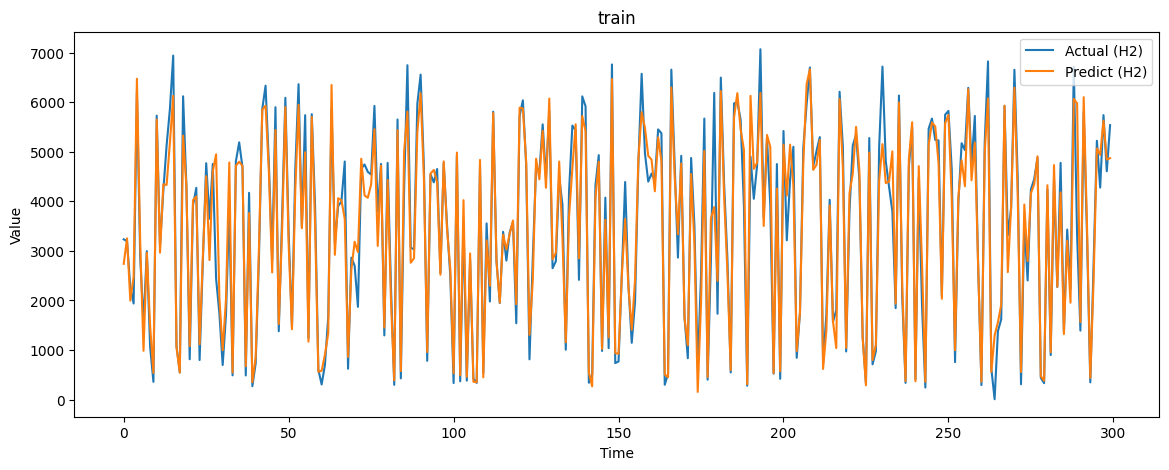

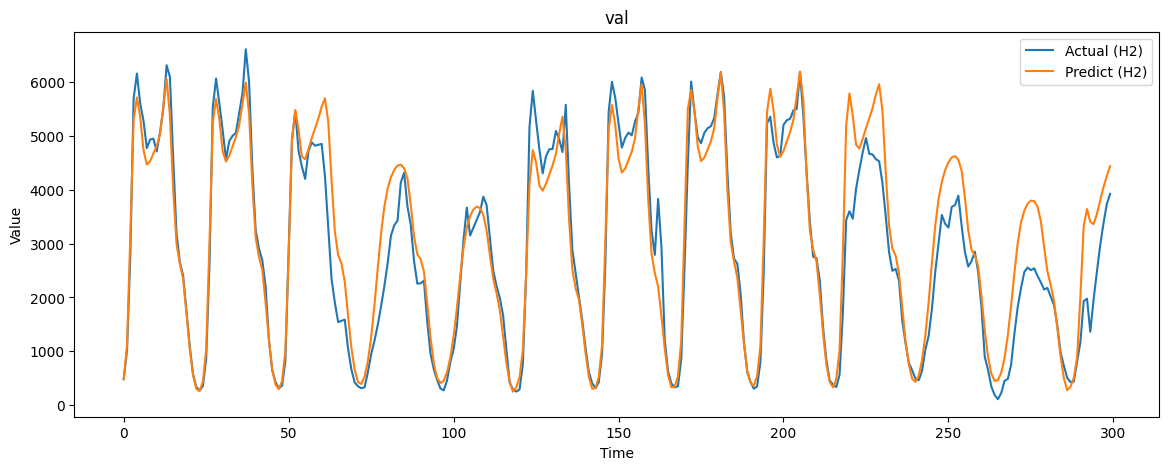

In [78]:
plot_horizon2(Y_train_inv, P_train_inv, 'train')
plot_horizon2(Y_val_inv, P_val_inv, 'val')

Hyperparameter tunning

In [79]:
def objective(trial):

    # Hyperparameters to tune
    hidden_dim  = trial.suggest_int("hidden_dim", 32, 256)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    teacher_forcing_ratio = trial.suggest_float("teacher_forcing_ratio", 0.3, 0.8)

    # Dataloaders
    train_loader_opt = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader_opt   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    # Model
    model = LSTMSeq2Seq(
        input_dim=19,
        hidden_dim=hidden_dim,
        output_dim=1,
        future_steps=horizon_task_2,
        num_layers=num_layers
    ).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_mae = float("inf")

    EPOCHS_OPT = 10
    for ep in range(EPOCHS_OPT):

        # ----------------------
        # TRAINING
        # ----------------------
        model.train()
        for xb, yb in train_loader_opt:
            xb = xb.to(CFG.device)
            yb = yb.to(CFG.device).unsqueeze(-1)  # (B, horizon, 1)

            optimizer.zero_grad()

            pred = model(
                xb,
                y=yb,
                teacher_forcing_ratio=teacher_forcing_ratio
            )  # (B, horizon, 1)

            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # ----------------------
        # VALIDATION (NO TF)
        # ----------------------
        model.eval()
        Ys, Ps = [], []

        with torch.no_grad():
            for xb, yb in val_loader_opt:
                xb = xb.to(CFG.device)

                # ensure shape (B, H, 1)
                if yb.dim() == 2:
                    yb_proc = yb.unsqueeze(-1)
                else:
                    yb_proc = yb

                pred = model(xb, y=None, teacher_forcing_ratio=0)

                Ys.append(yb_proc.cpu().numpy())
                Ps.append(pred.cpu().numpy())

        # Convert validation outputs
        Y_val = np.vstack(Ys)
        P_val = np.vstack(Ps)

        # inverse scaling: flatten → reshape → inverse → reshape back
        Y_flat = Y_val.reshape(-1, 1)
        P_flat = P_val.reshape(-1, 1)

        Y_inv = scaler_y.inverse_transform(Y_flat).reshape(Y_val.shape)
        P_inv = scaler_y.inverse_transform(P_flat).reshape(P_val.shape)

        # Compute MAE on inverse-scaled predictions
        val_mae = mean_absolute_error(
            Y_inv.reshape(-1),
            P_inv.reshape(-1)
        )

        trial.report(val_mae, ep)

        # update best
        if val_mae < best_val_mae:
            best_val_mae = val_mae

        # pruning
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial hyperparams:")
print(study.best_trial.params)
print("Best MAE:", study.best_trial.value)

[I 2025-12-03 04:43:27,788] A new study created in memory with name: no-name-2fc818ba-90a7-436d-a06d-eb11607e6cc0
[I 2025-12-03 04:44:23,858] Trial 0 finished with value: 252.6870574951172 and parameters: {'hidden_dim': 48, 'lr': 0.008737384739493682, 'batch_size': 64, 'num_layers': 3, 'teacher_forcing_ratio': 0.31724820861710545}. Best is trial 0 with value: 252.6870574951172.
[I 2025-12-03 04:44:44,852] Trial 1 finished with value: 255.36920166015625 and parameters: {'hidden_dim': 120, 'lr': 0.00160741447445571, 'batch_size': 128, 'num_layers': 1, 'teacher_forcing_ratio': 0.7872048595735321}. Best is trial 0 with value: 252.6870574951172.
[I 2025-12-03 04:46:55,159] Trial 2 finished with value: 260.72247314453125 and parameters: {'hidden_dim': 133, 'lr': 0.00012453487985953672, 'batch_size': 32, 'num_layers': 3, 'teacher_forcing_ratio': 0.5169398138079561}. Best is trial 0 with value: 252.6870574951172.
[I 2025-12-03 04:48:20,861] Trial 3 finished with value: 252.04637145996094 and p

Best trial hyperparams:
{'hidden_dim': 65, 'lr': 0.0015321813286814103, 'batch_size': 32, 'num_layers': 3, 'teacher_forcing_ratio': 0.3591866784236745}
Best MAE: 244.7786102294922


Best model

In [80]:
best_params = study.best_trial.params
hidden_dim = best_params["hidden_dim"]
lr          = best_params["lr"]
batch_size  = best_params["batch_size"]
teacher_forcing_ratio = best_params["teacher_forcing_ratio"]
num_layers = best_params["num_layers"]

train_loader_best = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_best   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader_best  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# Model final
encoder_decoder_model_best = LSTMSeq2Seq(
        input_dim=19,
        hidden_dim=hidden_dim,
        output_dim=1,
        future_steps=horizon_task_2,
        num_layers=num_layers
    ).to(CFG.device)

optimizer = torch.optim.Adam(encoder_decoder_model_best.parameters(), lr=lr)
criterion = nn.MSELoss()
train_model(encoder_decoder_model_best, train_loader_best, val_loader_best, optimizer, criterion, epochs=10, teacher_forcing_ratio=teacher_forcing_ratio, device=CFG.device)


# Evaluate Test
metrics_test, Y_test_inv, P_test_inv = evaluate_model_encoder_decoder(encoder_decoder_model_best, test_loader_best, scaler_y)
print("\nTest Metrics with best params:")
print(metrics_test)

Epoch 1/10 | Train Loss: 0.0133 | Val Loss: 0.0036
Epoch 2/10 | Train Loss: 0.0048 | Val Loss: 0.0033
Epoch 3/10 | Train Loss: 0.0044 | Val Loss: 0.0047
Epoch 4/10 | Train Loss: 0.0040 | Val Loss: 0.0035
Epoch 5/10 | Train Loss: 0.0035 | Val Loss: 0.0031
Epoch 6/10 | Train Loss: 0.0033 | Val Loss: 0.0043
Epoch 7/10 | Train Loss: 0.0033 | Val Loss: 0.0028
Epoch 8/10 | Train Loss: 0.0030 | Val Loss: 0.0034
Epoch 9/10 | Train Loss: 0.0031 | Val Loss: 0.0034
Epoch 10/10 | Train Loss: 0.0029 | Val Loss: 0.0029

Test Metrics with best params:
{'MAE': 295.7166748046875, 'RMSE': np.float64(442.2095621704714), 'NSE': np.float32(0.95033765), 'R2': 0.9503376483917236}


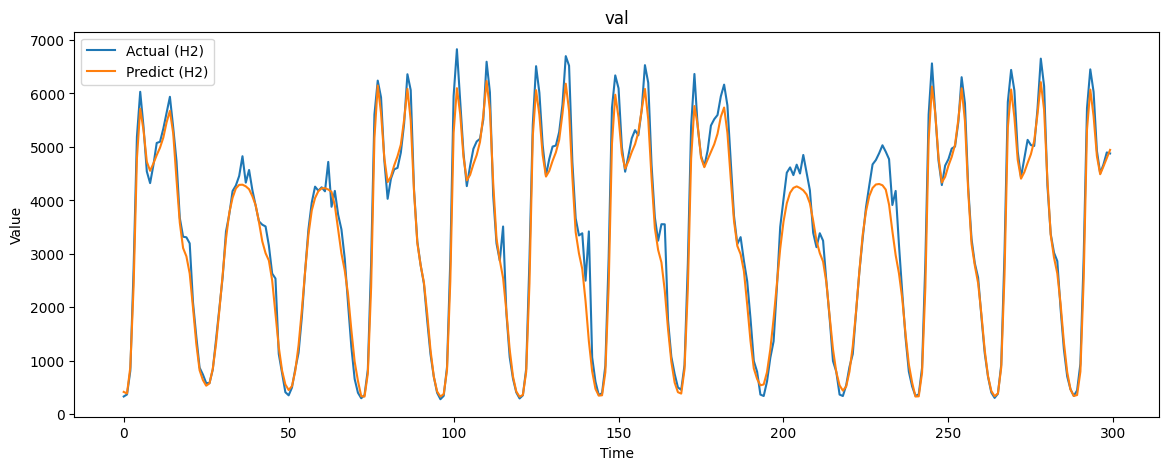

In [81]:
plot_horizon2(Y_test_inv, P_test_inv, 'val')